In [1]:
import sys
sys.path.append("..")
from allthethings import PyNetwork, PyPipe_ps
from allthethings import PyBC_opt_dh
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
from scipy import optimize
from writeit import rewritePipes


Populating the interactive namespace from numpy and matplotlib


In [2]:
fi = "../indata/Alamedanewer2.0.inp"
fc = "../indata/Alamedanewer2.0.config"
n0 = PyNetwork(fi,fc,1)
m_per_ft = .3048
elevs  =[417,414,324,300,275,256,232,201,177,190,192,197,199,206,209,240,252,250,283,289,316,315,334,340,334,332,333,341,387,426,417]

In [3]:
def idx_t(i,j,n,N):
    return (2*(N+2)*n+(N+2)*i+j)

In [4]:
#n0.showLayout()
Ls_m = [l*m_per_ft for l in n0.Ls]
elevs_m = [float(el)*m_per_ft for el in elevs]
#elevs_m = [0*float(el)*m_per_ft for el in elevs]
Ds_m = [D/12 for D in n0.Ds]
T = 20
Mi = 1   #number of time steps in between writes
Nt = 2
Ttot = Nt*T
Np = n0.Nedges
a = 100
Ns = [int(l) for l in Ls_m]
dx = [Ls_m[i]/Ns[i] for i in range(Np)]
M = int(T*a/(max(dx)*.8))*10
M = (M+Mi-M%Mi)  #round it up to be an even multiple of Mi
jt = n0.nodeTypes
Nn = len(jt)
bt = [1]*Nn
bv = [0.]*Nn
r = [1]*Nn
r[0] = 0
bt[0] =1
h0s = [0]*Np
q0s = [0]*Np
Mrs =[0.007]*Np
print T
print M
Nstar =1 #measuring point for each pipe
Hs =np.ndarray((Np,M/Mi*Nt))


20
23681


In [5]:
fn = "../indata/Alameda_m3"
oldinp = "../indata/Alamedanewer2.0.inp"
(fi, fc) = rewritePipes(fn,oldinp, Ns, Ls_m, Mrs, Ds_m, jt, bt, bv, r, h0s, q0s, T, M, a,elevs_m)
n1 = PyNetwork(fi,fc,1)
dt = n1.T/float(n1.M)
Q00 = 0.0087
A00 = 0.00793
for i in range(0,Np):
    A0 = 0*ones(n1.Ns[i])
    Q0 = 0*np.ones(n1.Ns[i])
    n1.setIC(i,A0,Q0)
#n1.setIC(0,A00*np.ones(n1.Ns[0]), Q00*np.ones(n1.Ns[0]))
#n1.setIC(1,A00*np.ones(n1.Ns[1]), Q00*np.ones(n1.Ns[1]))
Qb = Q00*np.ones(M+1)
Ab = A00*np.ones(M+1)
n1.setbVal(0,Qb)

new files are ../indata/Alameda_m3.inp and ../indata/Alameda_m3.config


In [6]:
%%time 
Vs = [n1.getTotalVolume()]
for m in range(Nt):
    n1.runForwardProblem(dt)
    for j in range(Np):
        N = n1.Ns[j]
        p0 = PyPipe_ps(N,n1.Ds[j], n1.Ls[j],M,a)
        qh = n1.qhist(j)
        Htemp = [p0.pbar(qh[idx_t(0,Nstar,n,n1.Ns[j])],False) for n in range(1,M+1,Mi)]
        Hs[j,m*(M/Mi):(M/Mi)*(m+1)] = Htemp
    Vs.append(n1.getTotalVolume()) 
    print m
    print Vs
    n1.reset()    

0
[0.0, 0.25486502426942437]
1
[0.0, 0.25486502426942437, 0.5113334145736874]
CPU times: user 2min 26s, sys: 3.39 s, total: 2min 29s
Wall time: 2min 30s


In [7]:
print m
print shape(Hs[j,m*(M/Mi):(M/Mi)*(m+1)])
print shape(Hs[j,m*(M/Mi):(M/Mi)*(m+1)])
print shape(Htemp)
print shape(range(1,M+1,Mi))

1
(23681,)
(23681,)
(23681,)
(23681,)


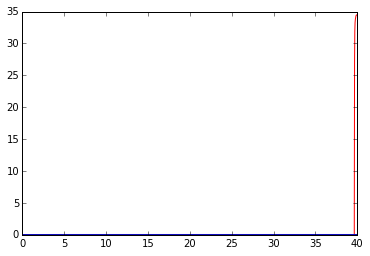

In [14]:
t = linspace(0,Ttot,shape(Hs)[1])
for k in range(0,Np):
    plot(t,Hs[k,:])

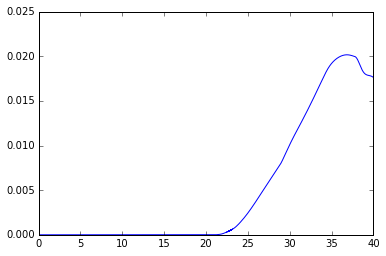

In [15]:
plot(t,Hs[18,:])

In [16]:
n1.solve_time*Nt

229.314638

54


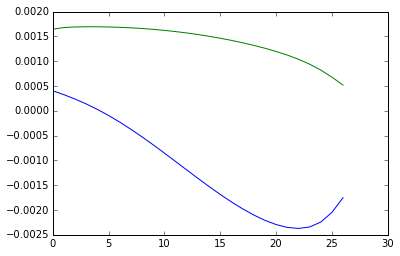

In [17]:
L = len(n1.q(18))
plot(n1.q(18)[L/2:])
print L
plot(n1.q(18)[0:L/2])

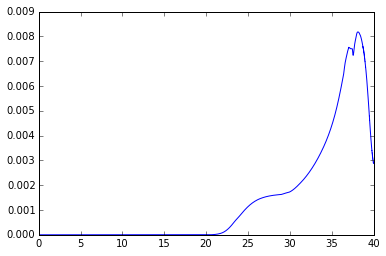

In [12]:
plot(t,Hs[19,:])

In [18]:
import pickle

In [23]:
solve_t = (n1.solve_time)*Nt
f1=  open('fillingdata_slopenot0.pkl','wb')
data = {'Hs':Hs, 'elevs':elevs_m,'T':T,
        'conns': n1.conn, 'Ds': n1.Ds, 'Ls':n1.Ls,
        'Mrs':Mrs,'M':M, 'Nt': Nt,'Ttot':Ttot,
        'Mi': Mi, 'a':a, 'solve_t':solve_t, 'Q00':'Q00',
        'notes':"initial condition zero everywhere. boundary condition is Q00 at node 0. all other junction ones are reflecting. base inp file is alamaded2.0.inp"}
pickle.dump(data,f1)
f1.close()

In [27]:
print dt*5

0.0042227946455


In [19]:
print Ttot

40


In [ ]:
0.004